<a name="top"><h1>Práctica 1: Predicci&oacute;n de los ingresos de Apple. Análisis </h1> </a>

<strong>Técnicas de Predicción: Series temporales</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>



<hr style="border:1px solid gray">

## Estructura

[1. Introducción](#introduccion) 

   - Objetivos específicos
    

[2. Importación de librerias](#importacion)

[3. Tratamiento de datos](#tratamiento)

[4. Graficación de la serie](#graficacion)

   - Serie temporal de todo el dataset
   - Análisis de estacionalidad
    
    
[5. Modelo ETS - Suavizado Exponencial (Automático)](#ets)

   - Predicción de valores de test
   - Predicción del resto del año 2021 y año 2022
     

[6. Modelo ETS - Suavizado Exponencial (Manual)](#manual)

   - Tendendencia aditiva y componente estacional multiplicativa
   - Tendendencia aditiva y sin componente estacional
   - Tendendencia multiplicativa y sin componente estacional
   - Sin tendencia y sin componente estacional
   - Sin tendencia y con componente estacional multiplicativo
   - Sin tendencia y con componente estacional aditivo
   - Con tendencia aditiva (Dumped y no dumped) y con componente estacional aditivo
     
     
[7. Modelo ARIMA (Autorregresivo integrado de media móvil)](#arima)

   - Predicción del resto del año 2021 y año 2022

[8. Comparación del modelo ETS vs Modelo ARIMA](#comparacion)

[9. Efecto COVID](#covid)

[10. Ingresos Anuales de Apple](#ingresos)

[11. Comparación de las predicciones del modelo ARIMA con las de Barclays ](#barclays)


## <a name="introduccion"> 1. Introducción </a>

En ésta primera práctica debemos predecir las ventas de Apple, utilizando los datos trimestrales desde el 1T de 1990 hasta el 2T del 2021 obtenidos de Bloomberg. Además, disponemos del último informe realizado por Barclays Research con las predicciones de los próximos trimestres hasta 2022 para ayudarnos con el proceso. 

Debemos tener en cuenta que al ser una compañía americana, las fechas que se nos han sido dadas vienen en trimestres de año fiscal. Los ingresos vienen dados en millones de dolares.

Trimestres en año fiscal:

- 1T: Octubre, Noviembre y Diciembre 
- 2T: Enero, Febrero y Marzo 
- 3T: Abril, Mayo y Junio 
- 4T: Julio, Agosto y Septiembre 

En este documento realizaremos el análisis y cálculos necesarios para dar respuesta a la cuestiones de la práctica. Las conclusiones y respuestas se podrán encontrar en el documento `Resultado_analisis_apple`

### 1.1. Objetivos específicos

- Aplicar la estimación y selección de modelos ETS.
- Aplicar la estimación y selección de modelos ARIMA.
- Determinar la precisión de las predicciones.

Además deberemos dar respuesta a las siguientes cuestiones:
- ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza?
- ¿Cuál es su tendencia? ¿y su componente estacional?
- ¿Cuales son las ventas anuales de Apple?
- ¿Cuales son los crecimientos anuales de los ingresos?
- ¿Qué modelo predice mejor?
- ¿Existe efecto COVID? Cuantificar.
- ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022?
- ¿Son creíbles las predicciones del Barclays?

## <a name="importacion">2. Importación de las librerias </a>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series # Graficar series
from sktime.forecasting.model_selection import temporal_train_test_split # Dividir dataset en train y test
from sktime.forecasting.ets import AutoETS # Modelo ETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error # Calcular  porcentaje MAE
from sktime.performance_metrics.forecasting import MeanSquaredError # Calcular MAE
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # Modelo ETS manual
from sktime.transformations.series.boxcox import LogTransformer # Transforamción Logarítmica
from sktime.forecasting.arima import AutoARIMA # Modelo ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de series temporales.
import warnings
warnings.filterwarnings('ignore')

## <a name="tratamiento">  3. Tratamiento de datos

Comprobamos que los datos vengan correctamente y realizamos las transfomaciones oportunas para poder trabajar con ellos de una manera correcta.

In [2]:
apple_df = pd.read_csv('aapl_ok.csv', sep = ';',decimal = ',' ) #Cargamos los datos, separados por ; y marcamos como se muestran los decimales en el origen
apple_df['fecha'] = pd.to_datetime(apple_df['fecha'], format="%m/%d/%Y") # Convertimos el tipo de datos de la columna fechas a datetime
apple_df['Trimeste'] = apple_df['Trimeste'].astype("string") # Convertimos el tipo de datos de la columna fechas a datetime.
apple_df = apple_df.set_index('fecha') # Fijamos como índice la columna fecha. 

Comprobación de valores duplicados y nulos:

In [3]:
duplicados = apple_df[apple_df.duplicated()] # Comprobamos si existen duplicados.
print(duplicados.count())

apple_df.isnull().sum() #Comprobamos si existen nulos.

Trimeste    0
Ingresos    0
dtype: int64


Trimeste    0
Ingresos    0
dtype: int64

Procedemos a convertir las fechas del dataframe a formato trimestral, **empezando por el mes de Octubre**, que corresponde al primer trimestre fiscal.

In [4]:
apple_trimestral= apple_df.resample("Q-OCT").last().drop("Trimeste", 1)  #Convertimos las fechas a trimestrales de año fiscal y eliminamos la columna de trimeste dado que no la vamos a necesitar.
apple_trimestral.tail(10) # Comprobamos que se haya realizado el cambio

,Ingresos
fecha,
2019-04-30,58015.0
2019-07-31,53809.0
2019-10-31,64040.0
2020-01-31,91819.0
2020-04-30,58313.0
2020-07-31,59685.0
2020-10-31,64698.0
2021-01-31,111439.0
2021-04-30,89584.0


## <a name="graficacion">  4. Graficación de la serie temporal </a>

En este apartado realizaremos un análisis para ver como se comporta la serie temporal de Apple

### 4.1 Serie temporal de todo el dataset

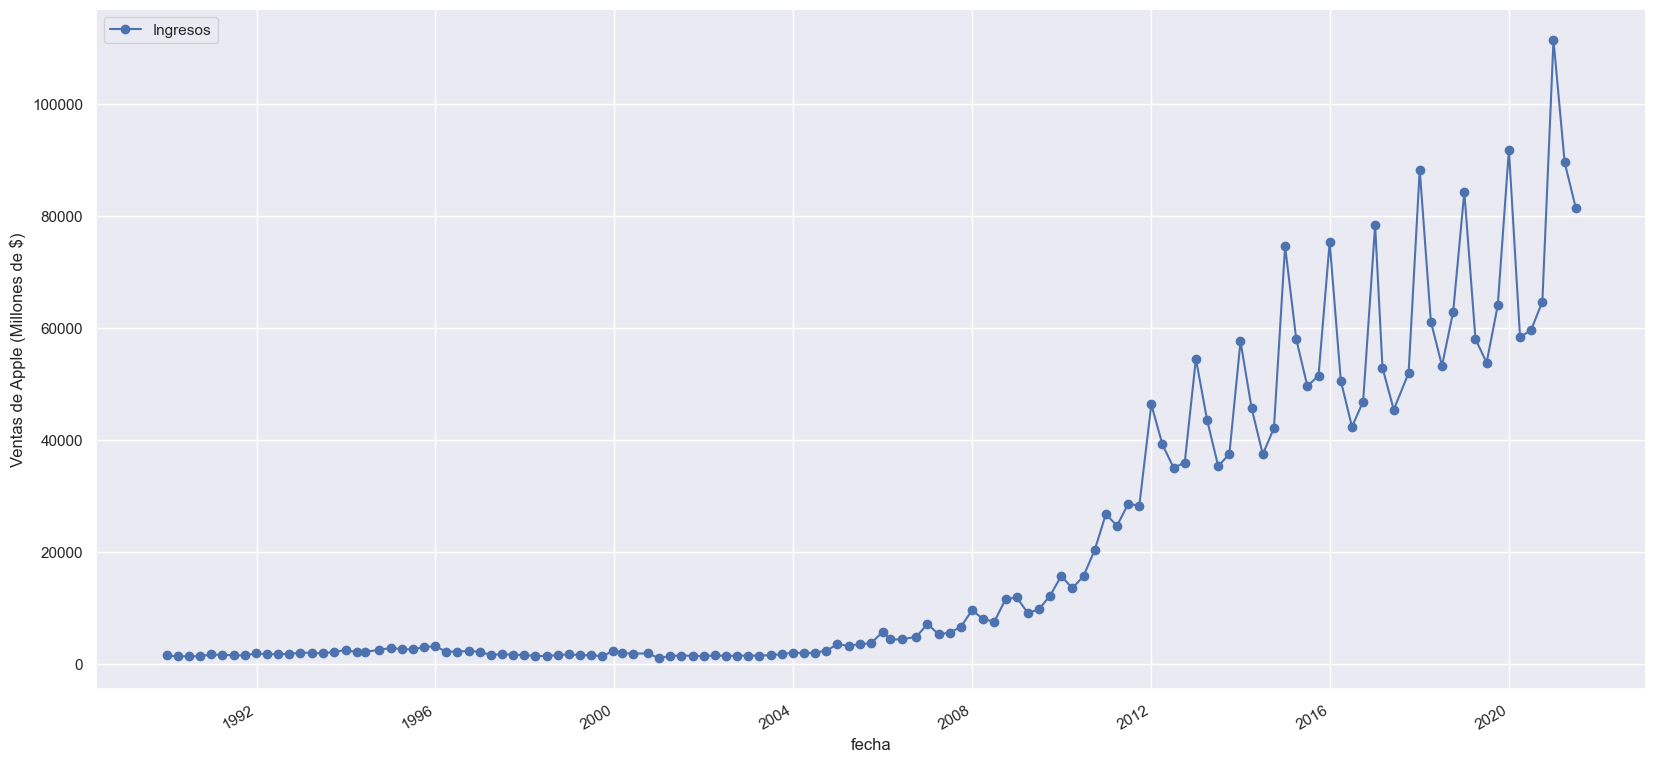

In [5]:
sns.set(rc={'figure.figsize':(20, 10)})
ax = apple_df.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas de Apple (Millones de $)');
plt.savefig('images/Apple_serie.png')

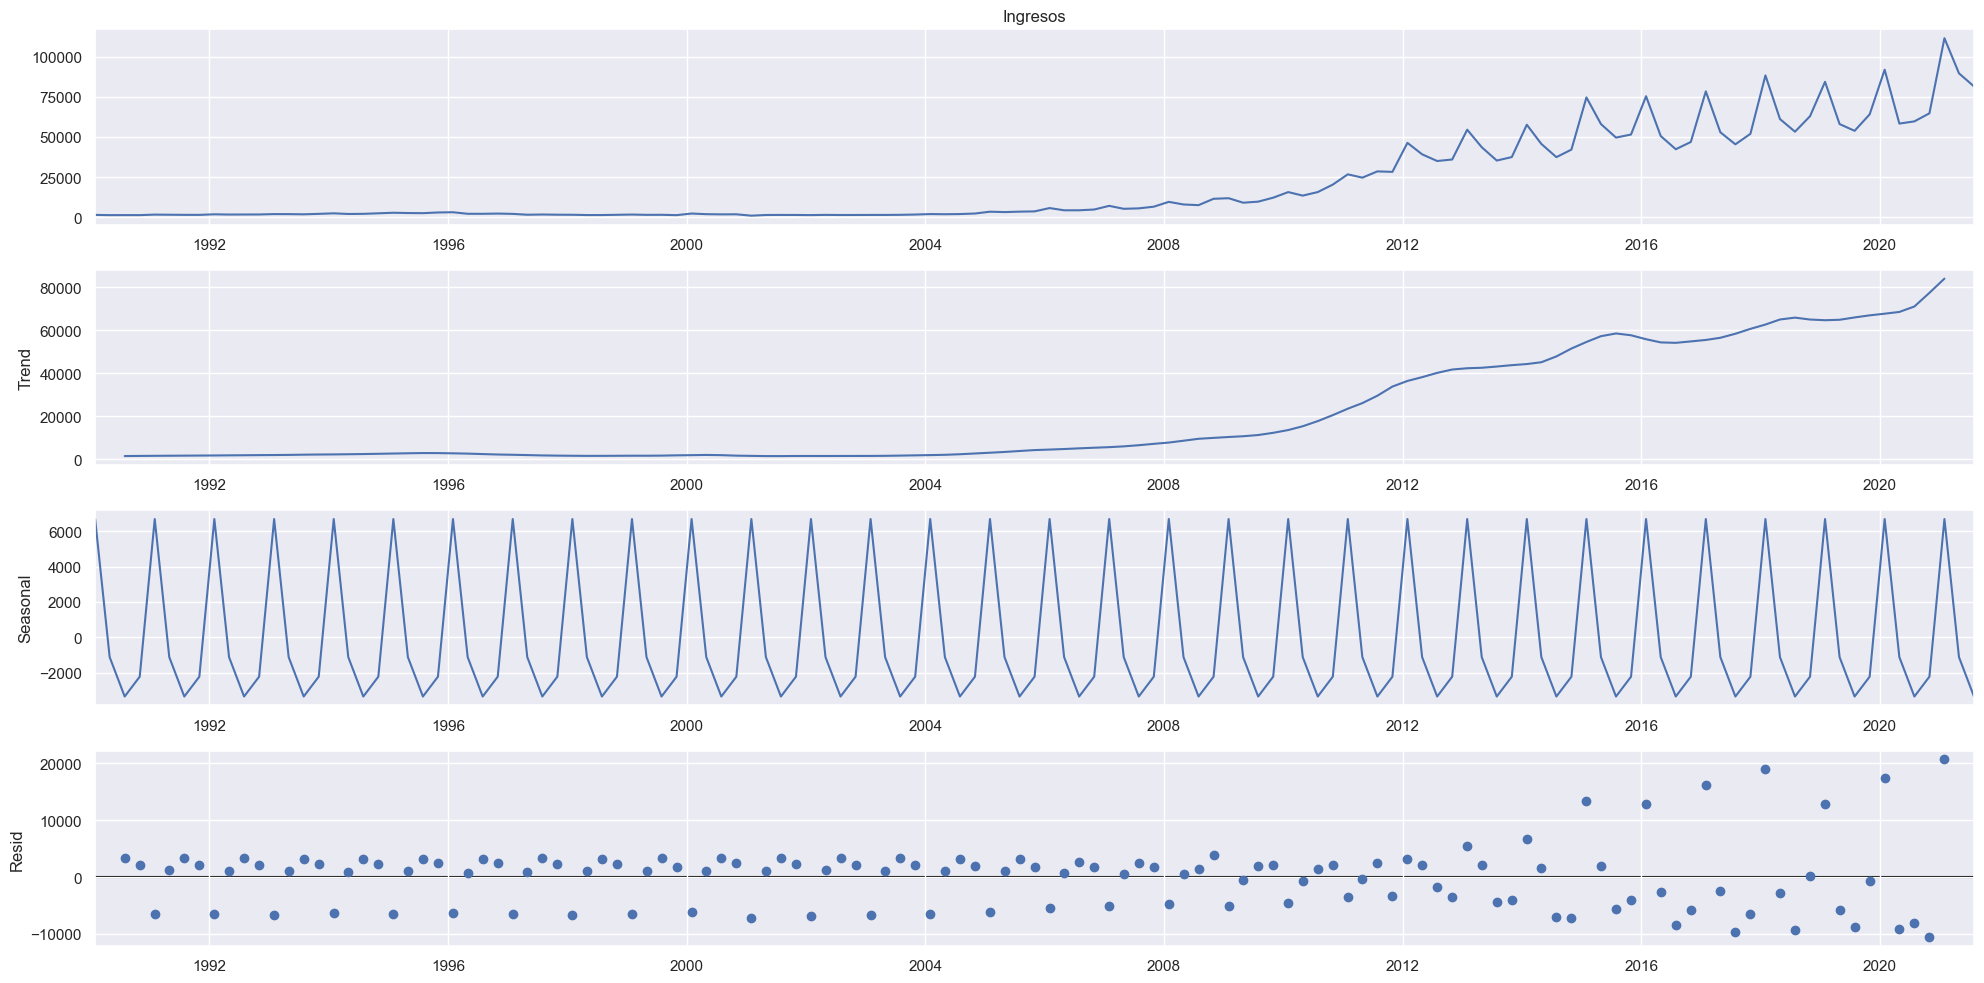

In [6]:
decomposition = seasonal_decompose(apple_trimestral['Ingresos'], period=4) # Descomponemos la serie para visualizar la tendencia 

decomposition.plot();
plt.savefig('images/descomposicion_serie.png')

Con estos gráficos pordemos observar como las ventas de Apple siguen una tendencia alcista a lo largo de los años, no son estacionarios en media y tampoco lo son en varianza. SIn embargo, observamos un componente estacional que procederemos a desarrollar.

### 4.1 Análisis de estacionalidad

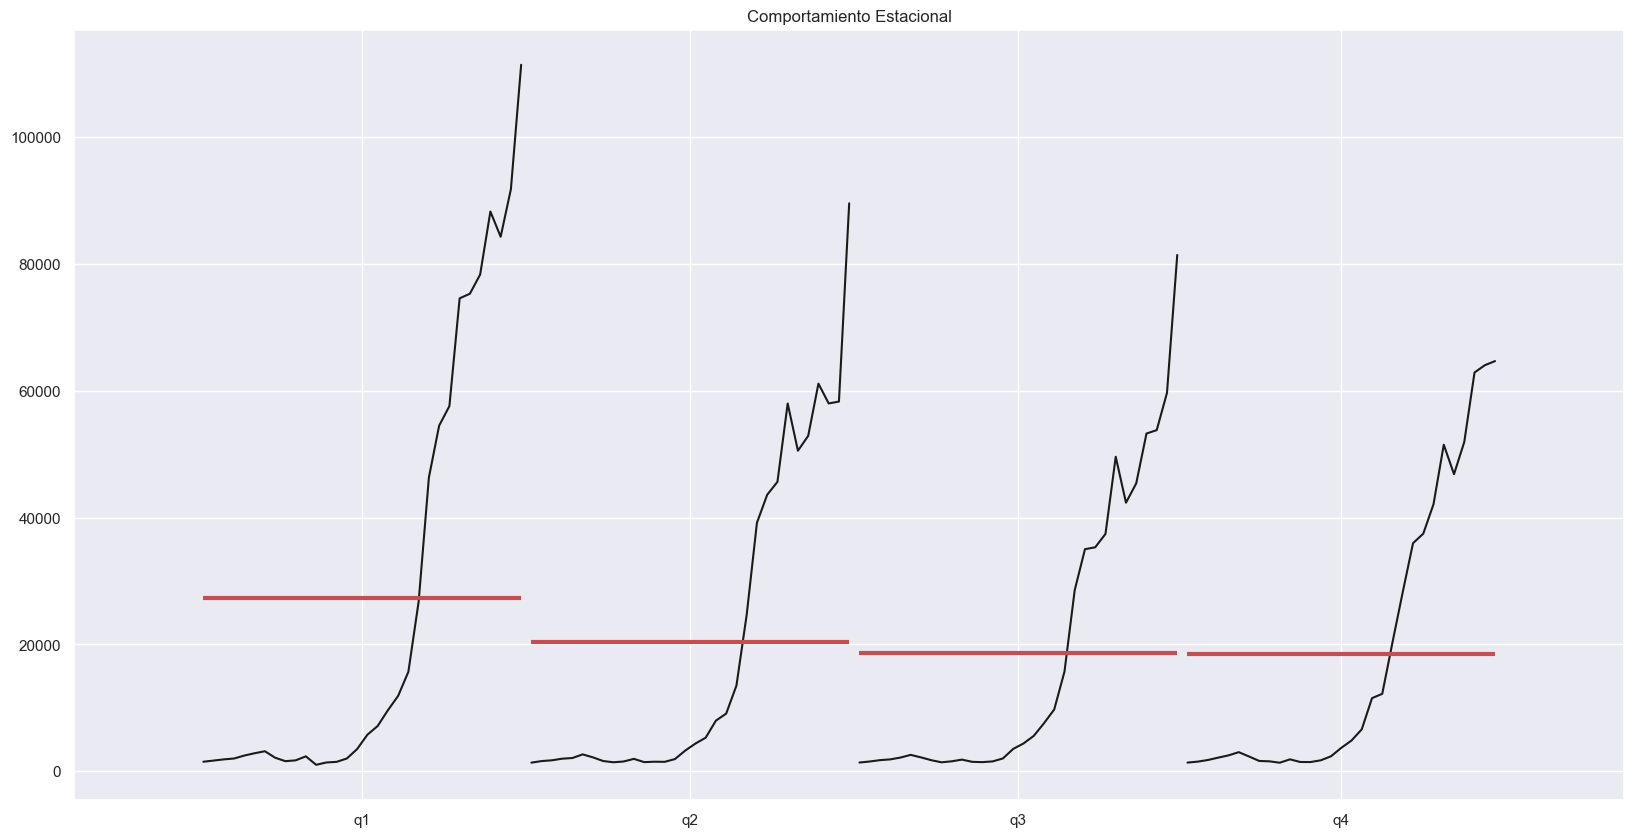

In [7]:
ax = plt.gca() # Representamos el componente estacional por trimestres
sm.graphics.tsa.quarter_plot(apple_trimestral['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')
plt.savefig('images/componente_estacional.png')

Como hemos comentado anteriormente la tendencia es claramente alcista, y observamos en el comportamiento estacional que claramente el nº de ventas en el primer trimestre fiscal es mucho mayor que el resto de trimestres.

Esto se puede deber a que durante los meses de Octubre, Noviembre y Diciembre, la compañía suele sacar al mercado las nuevas generaciones de sus productos potenciales, que son tanto hardware (iPhone, iPad, Macbook y Apple Watch) como software (Nueva versión de IOS y nuevos servicios en la nube).

Además a todo esto se le junta que durante este periodo existe un gran número de campañas comerciales como son el día del soltero (11/11, especialmente en China), Black Friday (25/11) y el periodo de Navidad (Diciembre).

### <a name="ets">  5.  Modelo ETS - Suavizado Exponencial (Automático) </a>

Para realizar las pruebas con diferentes modelos ETS, vamos a proceder a seleccionar nuestro set de Training y nuestro set de Test, siendo este último el conjunto de los últimos 8 trimestres.

In [8]:
# Seleccionamos los 8 ultimos valores como test y el resto como train. Además seleccionamos que las fechas se muestren como trimestres.

y_train, y_test = temporal_train_test_split(y=apple_trimestral['Ingresos'].astype('float64').to_period('Q-OCT'), test_size=8) 

119 8


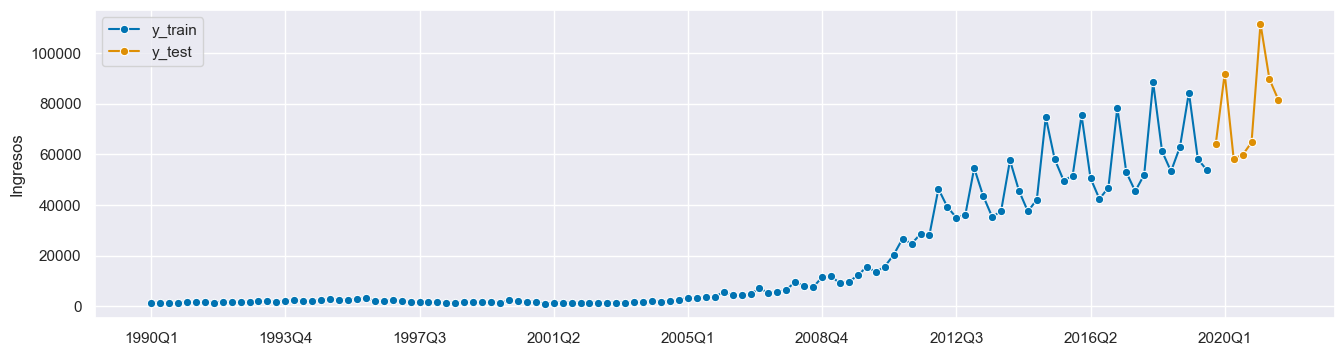

In [9]:
plot_series(y_train, y_test, labels=["y_train", "y_test"]) # Graficamos los dos datasets
print(y_train.shape[0], y_test.shape[0])

### Predicción de valores de test

Seleccionamos el número de trimestres que queremos prever, en este caso los que corresponden a la selección de test.

In [10]:
fh = np.arange(1, len(y_test)+1) # Seleccionamos el preiodo a predecir, 8 trimestres que equivalen al periodo de test.
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1) # Seleccionamos el modelo con estilo trimestral y n_jobs = -1 para utilizar todo el procesador .
apple_auto_model.fit(y_train) # Entrenamos el modelo

AutoETS(auto=True, n_jobs=-1, sp=4)

In [11]:
print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 07 Nov 2022   AIC                           1956.050
Time:                        09:53:19   BIC                           1983.841
Sample:                    01-31-1990   HQIC                          1967.335
                         - 07-31-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

Observamos las predicciones calculadas por el modelo para los trimestres de test y los comparamos graficamente:

In [12]:
apple_pred_auto = apple_auto_model.predict(fh)
print(apple_pred_auto)

2019Q4    58581.326742
2020Q1    85963.040159
2020Q2    59751.798679
2020Q3    53079.526151
2020Q4    58323.465808
2021Q1    85584.234646
2021Q2    59488.205472
2021Q3    52845.108937
Freq: Q-OCT, dtype: float64


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

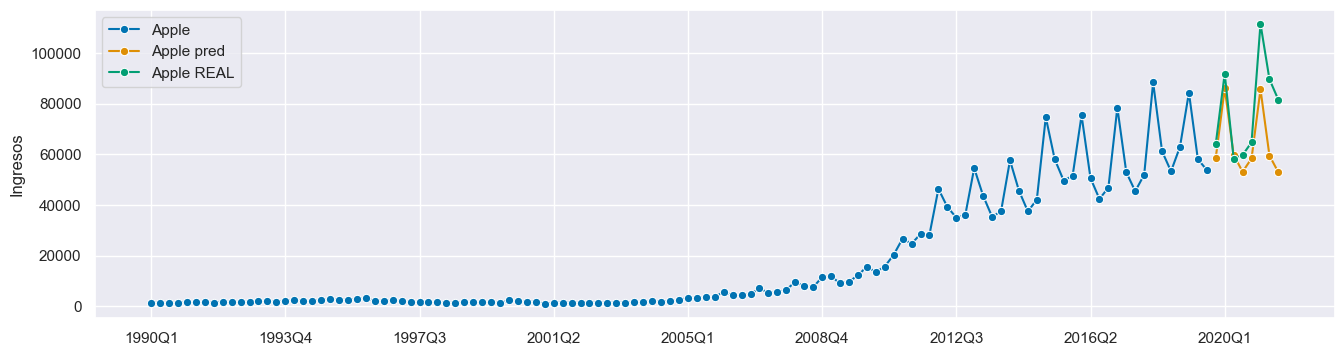

In [13]:
plot_series(y_train, apple_pred_auto,y_test, labels=["Apple", "Apple pred", "Apple REAL"]) #Graficación de predicciones y reales

Acercamos la gráfica con más detalle para ver las diferencias entre la predicción y la realidad.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

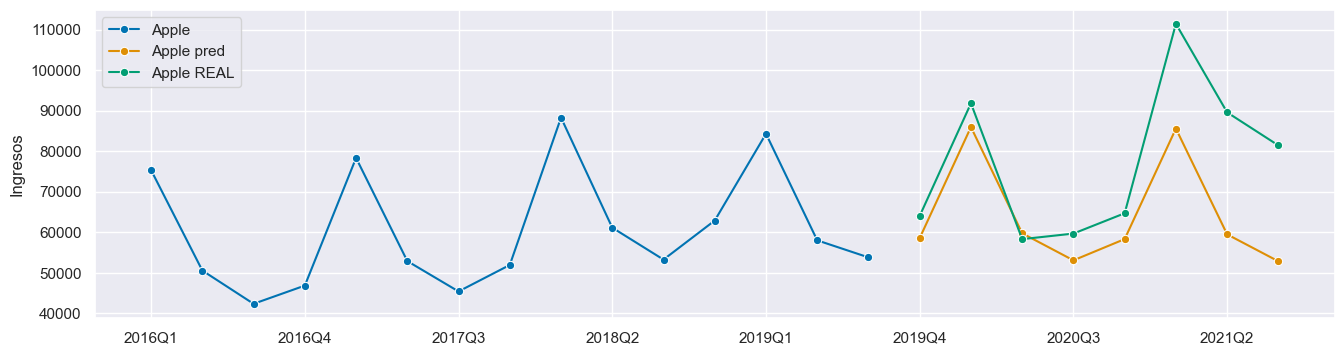

In [14]:
plot_series(y_train['2016':], apple_pred_auto, y_test, labels=["Apple", "Apple pred", "Apple REAL"])

Calculamos los errores del modelo utilizado

In [15]:
error_abs_per = mean_absolute_percentage_error(y_test, apple_pred_auto[0:8]) # Error medio porcentual.
mse = MeanSquaredError()
error_mse = mse(y_test, apple_pred_auto[0:8]) # Error cuadrático medio.
rmse = MeanSquaredError(square_root=True)
error_rmse = rmse(y_test, apple_pred_auto[0:8]) # Raíz cuadrada del error cuadrado medio 

print('El error absoluto medio porcentual es del ' + str(round(error_abs_per *100, 2)) + ' %')
print('El error cuadrático medio es de ' + str(round(error_mse , 2)))
print('La raíz cuadrada del error cuadrático medio es de ' + str(round(error_rmse , 2)))


El error absoluto medio porcentual es del 16.27 %
El error cuadrático medio es de 317747115.5
La raíz cuadrada del error cuadrático medio es de 17825.46


### Predicción del resto del año 2021 y año 2022

In [16]:
fh = np.arange(1, 7) # Correspondiente a los 6 triemstres que quedan hasta final del 2022
apple_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)
y = apple_trimestral['Ingresos'].astype('float64').to_period('Q-OCT')
apple_auto_model.fit(y)
print(apple_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.310
Date:                Mon, 07 Nov 2022   AIC                           2124.620
Time:                        09:53:20   BIC                           2153.062
Sample:                    01-31-1990   HQIC                          2136.176
                         - 07-31-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal  

In [17]:
apple_pred = apple_auto_model.predict(fh)
print(apple_pred)

2021Q4     94928.198386
2022Q1    153907.759505
2022Q2    112068.409844
2022Q3    104446.057804
2022Q4    120404.562349
2023Q1    192615.706400
Freq: Q-OCT, dtype: float64


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

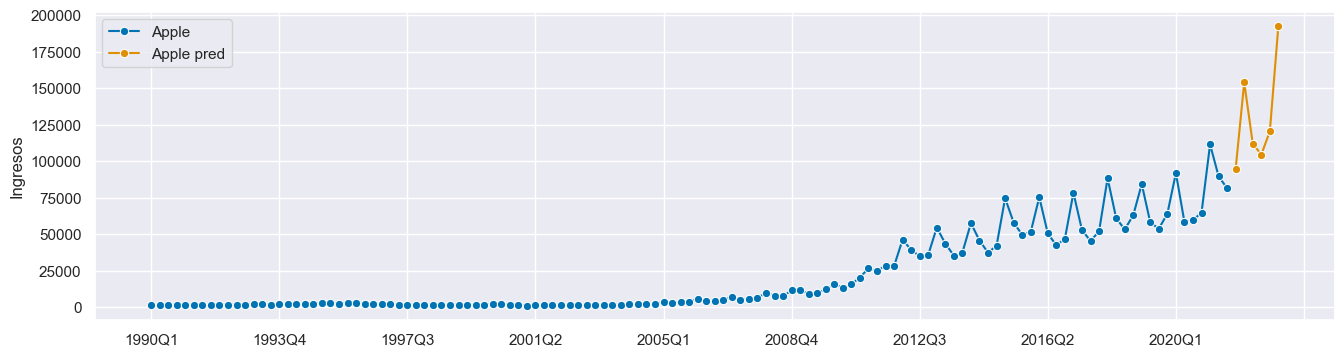

In [18]:
plot_series(y, apple_pred, labels=["Apple", "Apple pred"])

 ## <a name="manual">  6. Modelo ETS - Suavizado Exponencial (Manual)</a>

### Tendendencia aditiva y componente estacional multiplicativa 

In [19]:
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=4)
forecaster.fit(y)


ExponentialSmoothing(seasonal='multiplicative', sp=4, trend='additive')

In [20]:
y_pred = forecaster.predict(fh)
y_pred

2021Q4     89911.087953
2022Q1    140067.871689
2022Q2     98561.116899
2022Q3     88902.618892
2022Q4     97928.137407
2023Q1    152284.884957
Freq: Q-OCT, Name: Ingresos, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

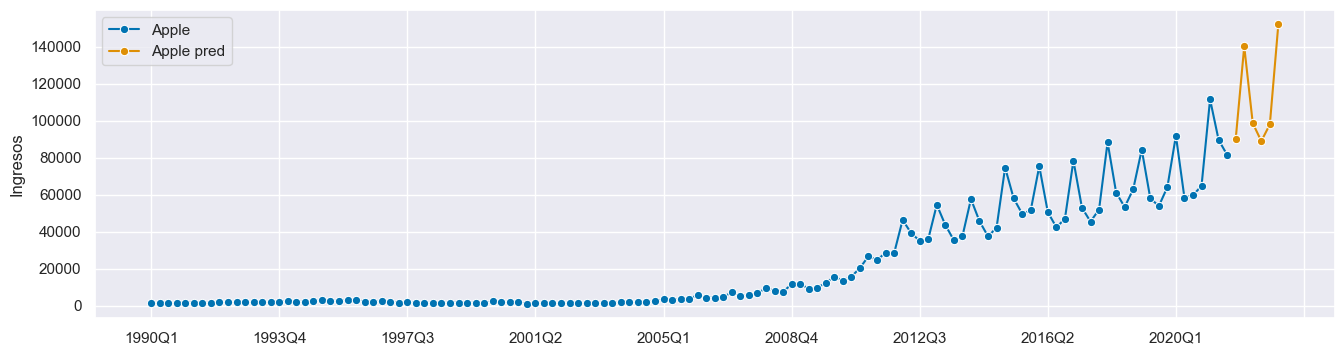

In [21]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])


### Tendendencia aditiva y sin componente estacional

In [22]:
forecaster = ExponentialSmoothing(trend='additive', seasonal=None, sp=4)
forecaster.fit(y)


ExponentialSmoothing(sp=4, trend='additive')

In [23]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

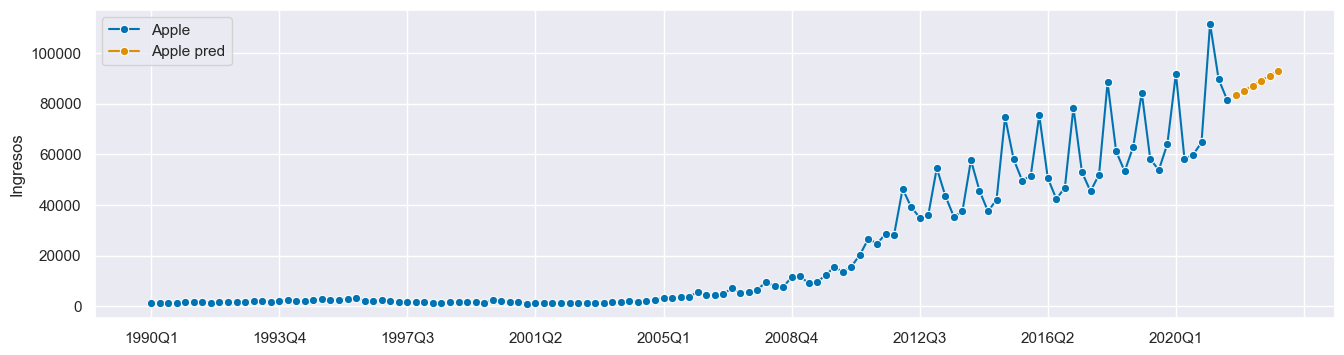

In [24]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])

### Tendendencia multiplicativa y sin componente estacional

In [25]:
forecaster = ExponentialSmoothing(trend='mul', seasonal=None, sp=4)
forecaster.fit(y)


ExponentialSmoothing(sp=4, trend='mul')

In [26]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

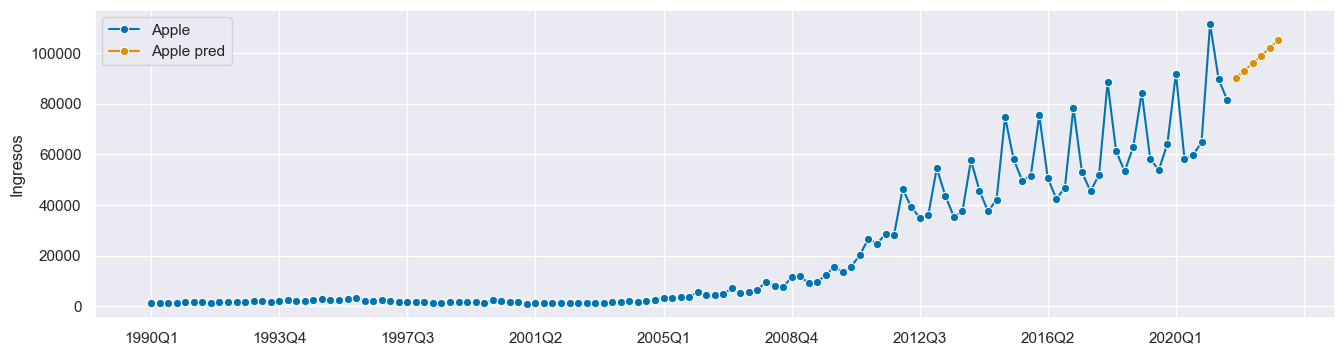

In [27]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])

### Sin tendencia y sin componente estacional

In [28]:
forecaster = ExponentialSmoothing(trend=None, seasonal=None, sp=4)
forecaster.fit(y)

ExponentialSmoothing(sp=4)

In [29]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

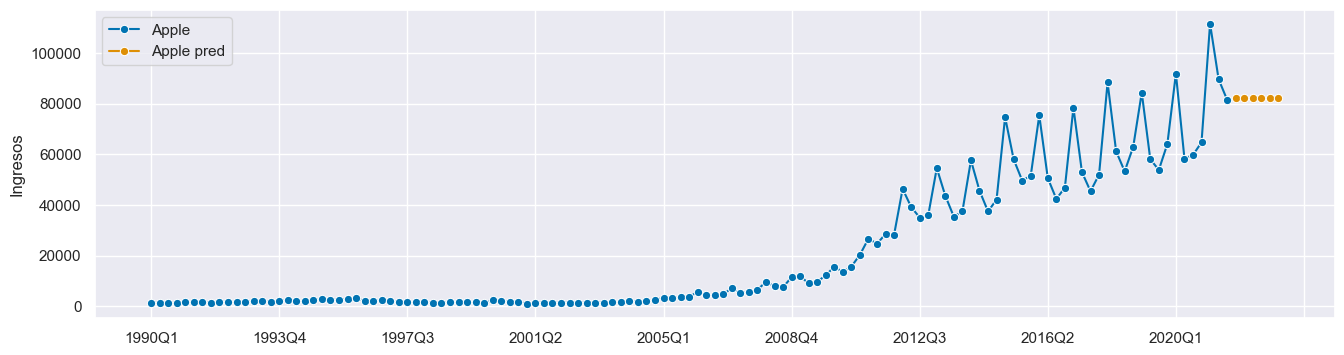

In [30]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])

### Sin tendencia y con componente estacional multiplicativo

In [31]:
forecaster = ExponentialSmoothing(trend=None, seasonal='mul', sp=4)
forecaster.fit(y)

ExponentialSmoothing(seasonal='mul', sp=4)

In [32]:
y_pred = forecaster.predict(fh)

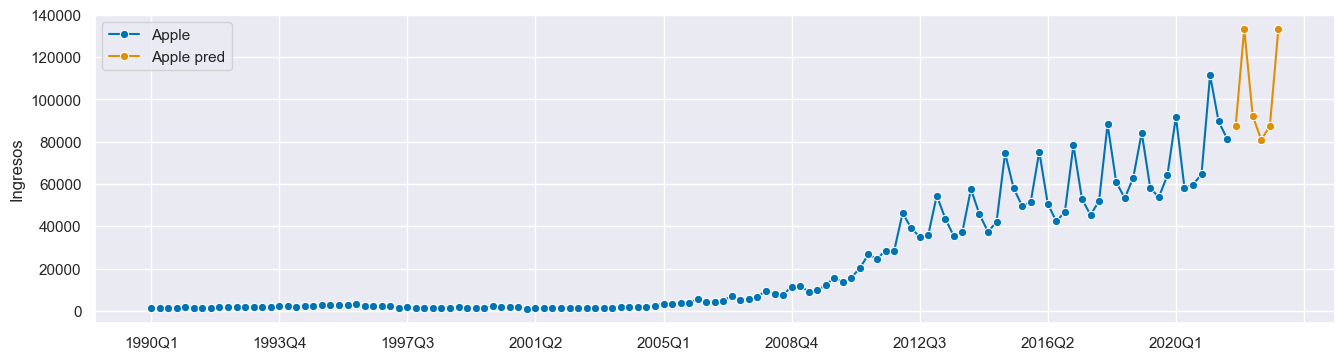

In [33]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])
plt.show()

### Sin tendencia y con componente estacional aditivo

In [34]:
forecaster = ExponentialSmoothing(trend=None, seasonal='additive', sp=4)
forecaster.fit(y)

ExponentialSmoothing(seasonal='additive', sp=4)

In [35]:
y_pred = forecaster.predict(fh)

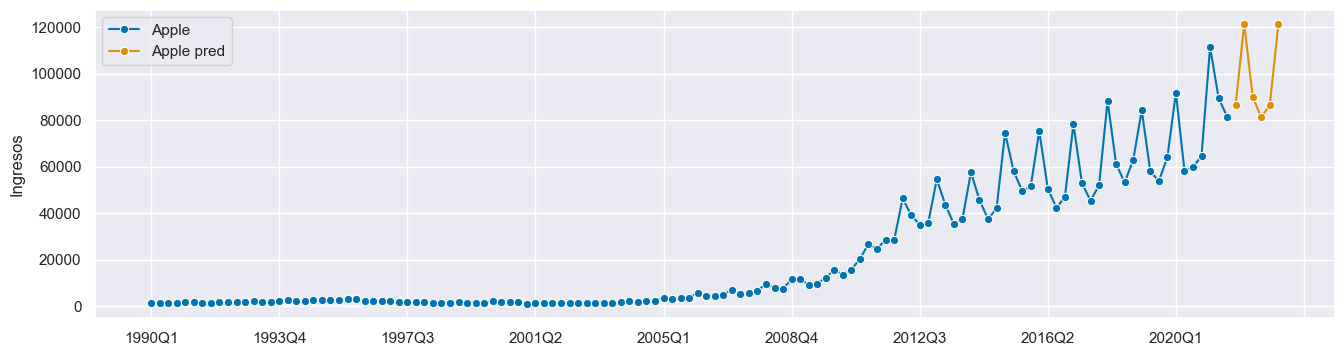

In [36]:
plot_series(y, y_pred, labels=["Apple", "Apple pred"])
plt.show()

### Con tendencia aditiva (Dumped y no dumped) y con componente estacional aditivo

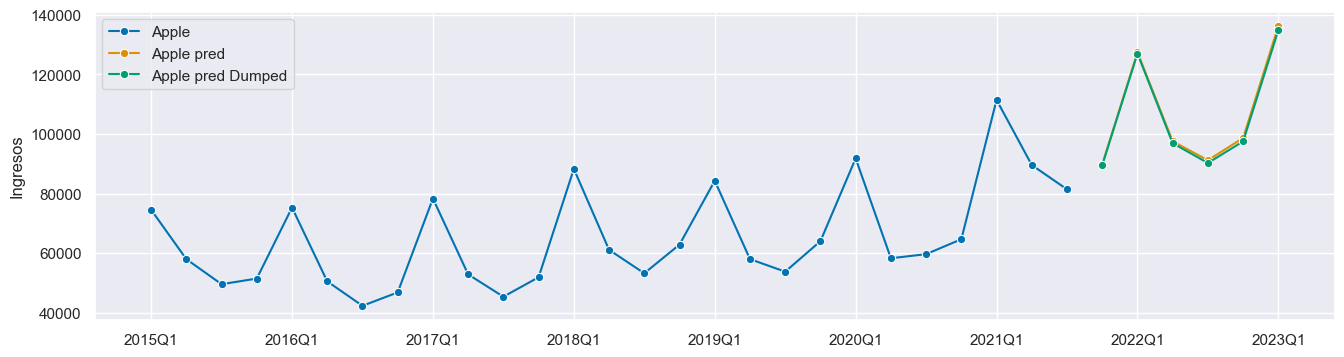

In [37]:
forecaster = ExponentialSmoothing(trend="additive",seasonal="additive",damped_trend=False, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)

forecaster = ExponentialSmoothing(trend="additive",seasonal="additive",damped_trend=True, sp=4)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh)
plot_series(y["2015":], y_pred, y_pred_dump,labels=["Apple", "Apple pred","Apple pred Dumped"]);

## <a name="arima">  7. Modelo ARIMA (Autorregresivo integrado de media móvil) </a>

Pasamos los datos a trimestrales

In [38]:
apple_trimestral_q = apple_trimestral['Ingresos'].astype('float64').to_period('Q-OCT')

Transformación Logarítmica

In [39]:
transformer = LogTransformer()
log_apple_trimestral= transformer.fit_transform(apple_trimestral_q)
log_apple_trimestral.tail()

fecha
2020Q3    10.996836
2020Q4    11.077486
2021Q1    11.621233
2021Q2    11.402932
2021Q3    11.307548
Freq: Q-OCT, dtype: float64

Commparamos la serie original con la transformada logaritmicamente:

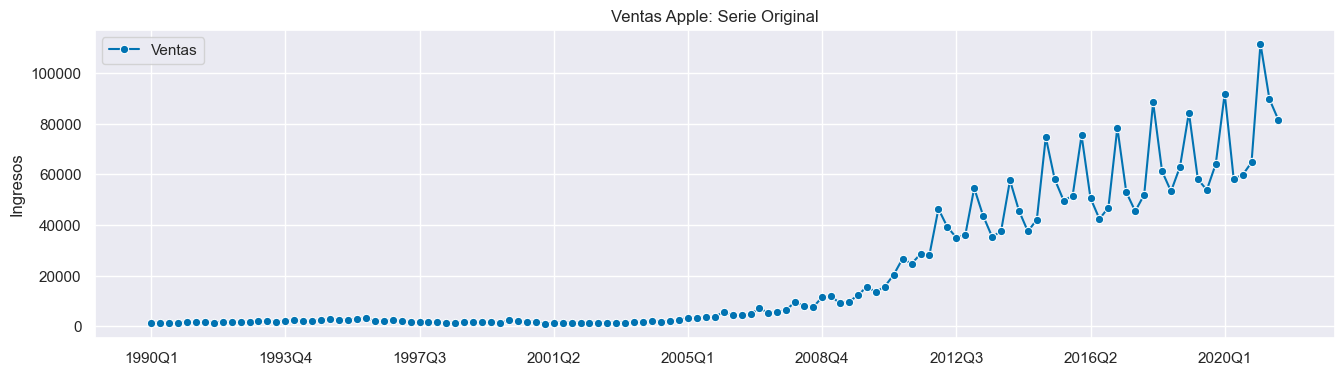

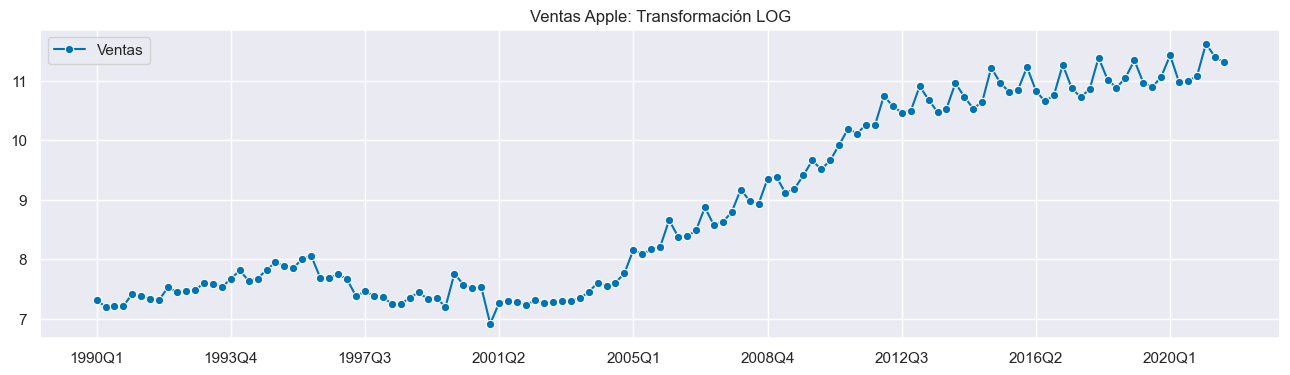

In [40]:
fig, ax =plot_series(apple_trimestral_q, labels=["Ventas"])

ax.set_title('Ventas Apple: Serie Original');

fig, ax =plot_series(log_apple_trimestral, labels=["Ventas"])

ax.set_title('Ventas Apple: Transformación LOG');

Selección de valores de train y test:

In [41]:
log_y_train, log_y_test = temporal_train_test_split(y =log_apple_trimestral, test_size=8) #Seleccionamos los 8 ultimos como test para los log.
y_train, y_test = temporal_train_test_split(y = apple_trimestral_q, test_size= 8) # Seleccionamos loos 8 ultimos valores como test.


119 8


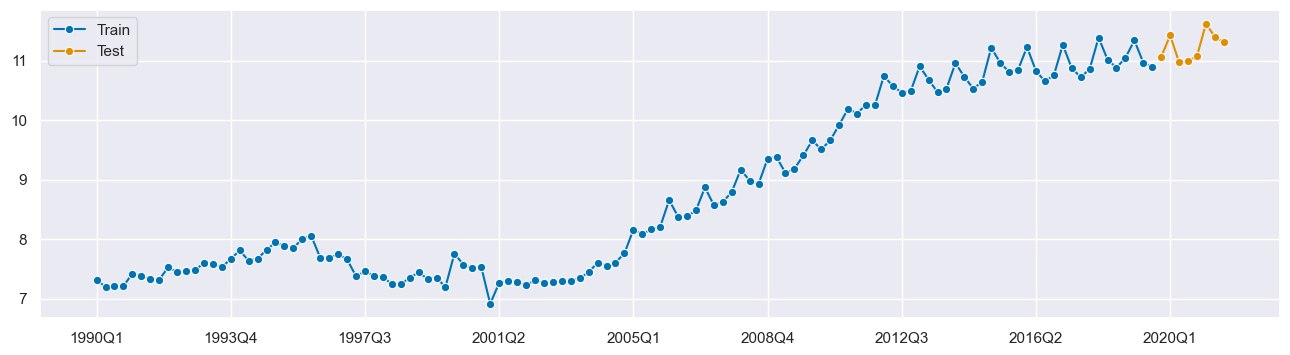

In [42]:
plot_series(log_y_train, log_y_test, labels=["Train", "Test"])
print(y_train.shape[0], y_test.shape[0])


Seleccionamos para predecir los trimestres de la selección de test 

In [43]:
fh = np.arange(1, len(y_test)+1)  # forecasting horizon

In [44]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [45]:
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 07 Nov 2022   AIC                           -108.724
Time:                                   09:53:46   BIC                            -97.642
Sample:                               01-31-1990   HQIC                          -104.224
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

In [46]:
log_y_pred = forecaster.predict(fh)
log_y_pred

2019Q4    11.005157
2020Q1    11.335676
2020Q2    11.027215
2020Q3    10.934800
2020Q4    11.039460
2021Q1    11.342073
2021Q2    11.059655
2021Q3    10.975044
Freq: Q-OCT, dtype: float64

Calculamos los valores de prediccioón sin transformación logarítmica:

In [47]:
apple_pred_arima1 = np.exp(log_y_pred)

Calculamos los errores de predicción del modelo ARIMA:

In [48]:
arima_error_abs_per = mean_absolute_percentage_error(y_test,  np.exp(log_y_pred)) # Error medio porcentual.
mse = MeanSquaredError()
arima_error_mse = mse(y_test, np.exp(log_y_pred)) # Error cuadrático medio.
rmse = MeanSquaredError(square_root=True)
arima_error_rmse = rmse(y_test,  np.exp(log_y_pred)) # Raíz cuadrada del error cuadrado medio 

print('El error absoluto medio porcentual es del ' + str(round(arima_error_abs_per *100, 2)) + ' %')
print('El error cuadrático medio es de ' + str(round(arima_error_mse , 2)))
print('La raíz cuadrada del error cuadrático medio es de ' + str(round(arima_error_rmse , 2)))

El error absoluto medio porcentual es del 13.97 %
El error cuadrático medio es de 256736423.27
La raíz cuadrada del error cuadrático medio es de 16023.0


Visualizamos graficamente la predicción del modelo ARIMA

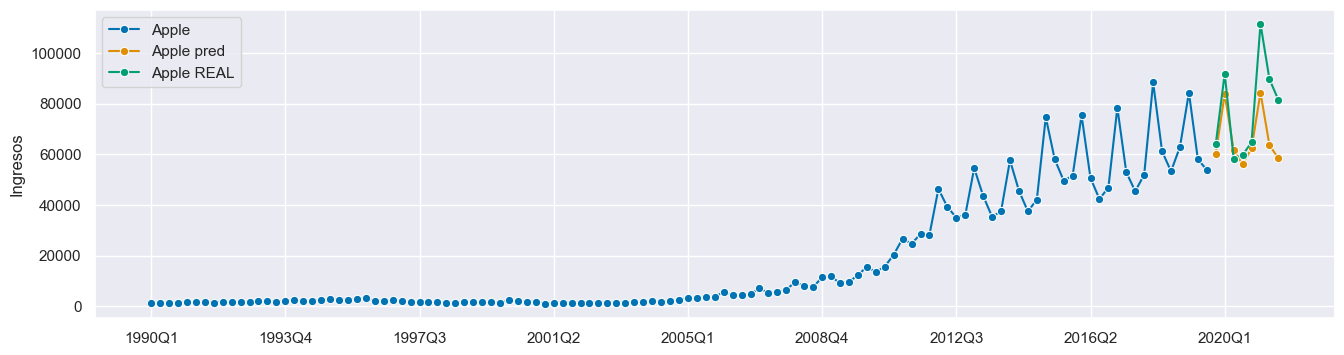

In [49]:
plot_series(y_train, apple_pred_arima1,y_test, labels=["Apple", "Apple pred", "Apple REAL"])
plt.show()

Acercamos un poco más la gráfica para ver mas minuciosamnete la diferencia entre la predicción y los valores reales

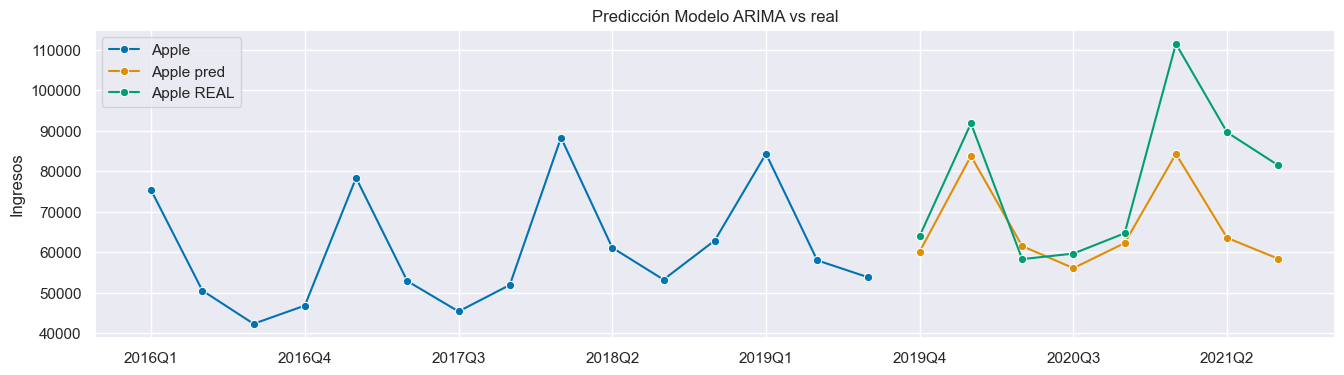

In [50]:
plot_series(y_train['2016':], np.exp(log_y_pred), y_test, labels=["Apple", "Apple pred", "Apple REAL"])
plt.title('Predicción Modelo ARIMA vs real')
plt.show()

###  Predicción del resto del año 2021 y año 2022

In [51]:
fh = np.arange(1,7)  # Seleccionamos como forecast los 6 próximos trimestres
fh

array([1, 2, 3, 4, 5, 6])

In [52]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_apple_trimestral)

AutoARIMA(sp=4, suppress_warnings=True)

In [53]:
print(forecaster.summary()) #Imprimimos el resumen

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 4)   Log Likelihood                  64.270
Date:                             Mon, 07 Nov 2022   AIC                           -118.539
Time:                                     09:54:08   BIC                           -104.358
Sample:                                 01-31-1990   HQIC                          -112.778
                                      - 07-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3231      0.079     -4.096      0.000      -0.478      -0.168
ar.L2         -0.1575      

Observamos los resultados de la predicción en formato logarítmico.

In [54]:
log_y_pred = forecaster.predict(fh)
log_y_pred

2021Q4    11.406398
2022Q1    11.810570
2022Q2    11.532827
2022Q3    11.470460
2022Q4    11.565871
2023Q1    11.939248
Freq: Q-OCT, dtype: float64

Ahora deshacemos la transformación logarítmica de los resultados:

In [55]:
apple_pred_arima2 = np.exp(log_y_pred)
apple_pred_arima2

2021Q4     89895.062074
2022Q1    134668.286866
2022Q2    102010.040186
2022Q3     95842.393032
2022Q4    105437.179882
2023Q1    153161.501747
Freq: Q-OCT, dtype: float64

Visualizamos en una gráfica la predicción:

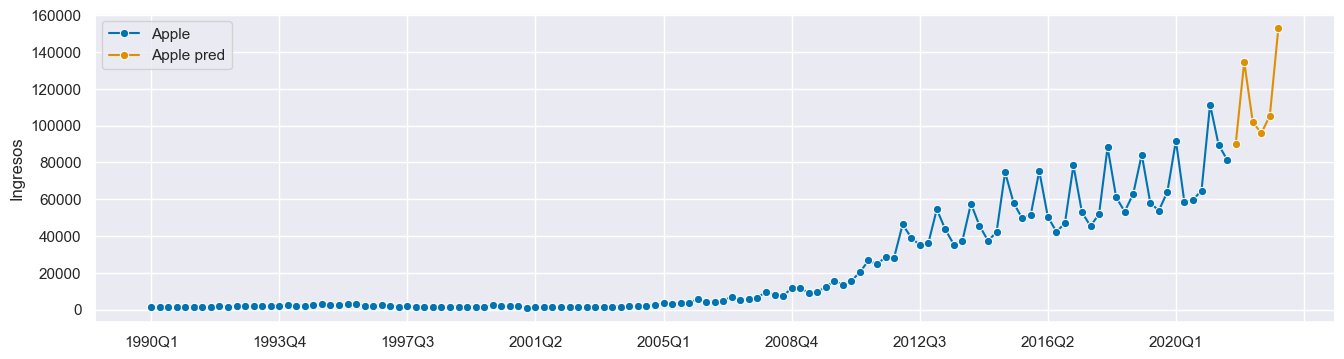

In [56]:
plot_series(apple_trimestral_q, apple_pred_arima2, labels=["Apple", "Apple pred"])
plt.show()

## <a name="comparacion">  8. Comparación del modelo  ETS vs Modelo ARIMA  </a>

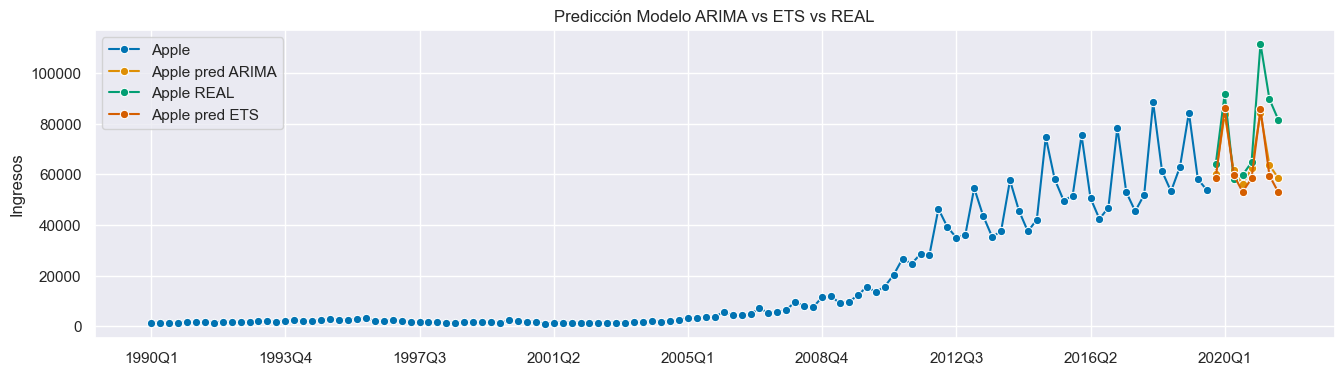

In [57]:
plot_series(y_train, apple_pred_arima1, y_test, apple_pred_auto, labels=["Apple", "Apple pred ARIMA", "Apple REAL","Apple pred ETS"])
plt.title('Predicción Modelo ARIMA vs ETS vs REAL')
plt.show()

Seleccionamos la gráfica desde el año 2019 para poder ver con más detalle la diferencia entre los modelos y los valores reales

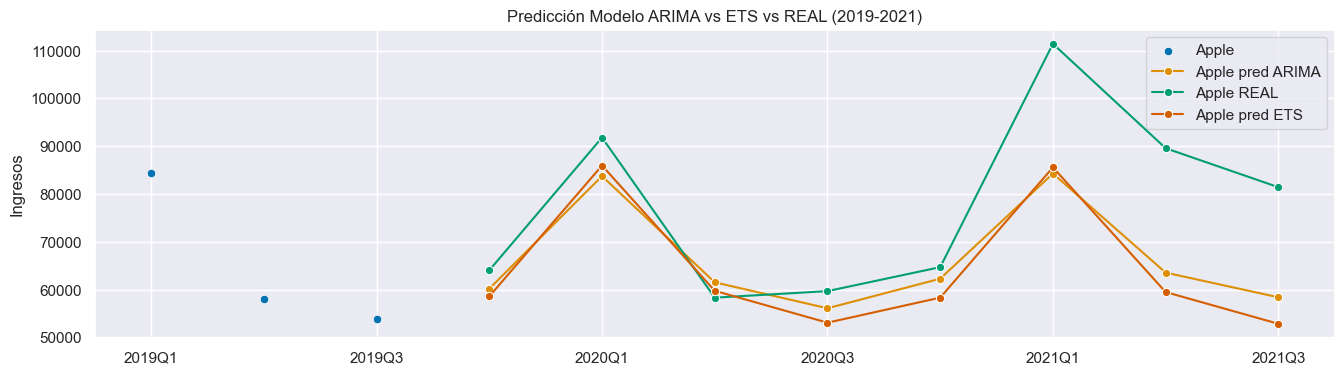

In [58]:
plot_series(y_train['2019':], apple_pred_arima1, y_test, apple_pred_auto, labels=["Apple", "Apple pred ARIMA", "Apple REAL","Apple pred ETS"])
plt.title('Predicción Modelo ARIMA vs ETS vs REAL (2019-2021)')
plt.show()

Observamos los valores que existen entre los diferentes modelos para ver cual es el más preciso.

In [59]:
print('El error absoluto medio porcentual ETS es del ' + str(round(error_abs_per *100, 2)) + ' % , ')
print('El error absoluto medio porcentual ARIMA es del ' + str(round(arima_error_abs_per *100, 2)) + ' %')

print('El error cuadrático medio ETS es de ' + str(round(error_mse , 2)))
print('El error cuadrático medio ARIMA es de ' + str(round(arima_error_mse , 2)))

print('La raíz cuadrada del error cuadrático medio ETS es de ' + str(round(error_rmse , 2)))
print('La raíz cuadrada del error cuadrático medio ARIMA es de ' + str(round(arima_error_rmse , 2)))

El error absoluto medio porcentual ETS es del 16.27 % , 
El error absoluto medio porcentual ARIMA es del 13.97 %
El error cuadrático medio ETS es de 317747115.5
El error cuadrático medio ARIMA es de 256736423.27
La raíz cuadrada del error cuadrático medio ETS es de 17825.46
La raíz cuadrada del error cuadrático medio ARIMA es de 16023.0


Observamos que el modelo ARIMA tiene un menor error que el Modelo ETS, por lo que nos quedaremos con las predicciones del ARIMA al obtener mejor predicciones y ser por ello más fiable. 

## <a name="covid">  9. Efecto COVID</a>

Para comprobar el efecto covid, reflejaremos los ingresos anuales y los predecidos por ARIMA, junto a su diferencia.

In [60]:
#Creamos un DF donde podemos visualizar los ingresos reales, los predichos y la diferencia
revenue_df = pd.DataFrame({'Ingresos (Millones USD)': round(y_test,0) , 'ARIMA (Millones USD)': round(apple_pred_arima1,2) , 'Diferencia (Millones USD)':round(y_test-apple_pred_arima1,2)})

Dado que el COVID surgió a finales de 2020 en China unicamente, tendremos en cuenta que afectó a la compañia a partir del segundo trimestre fiscal en 2020 (Febrero- Marzo) dado que mundialmente la gran cantidad de confinamientos surgieron a partir de esas fechas.

Es por ello que para el cálculo del efecto lo realizaremos hasta el momento donde comenzaron a administarse las primeras dosis (1Q 2021) de la vacuna, que es cuando empezó a verse el buen funcionamiento de las mismas y a flexibilizar las medidas, logrando la ansiada 'normalidad'.

In [61]:
covid_effect = revenue_df.drop(['2019Q4', '2020Q1', '2021Q2', '2021Q3'],axis=0)

In [62]:
print('El impacto del COVID hasta septiembre de 2020 fue de ' + str(round(covid_effect['Diferencia (Millones USD)'].sum() /1000, 2)) +' billones de USD')

covid_effect


El impacto del COVID hasta septiembre de 2020 fue de 29.94 billones de USD


,Ingresos (Millones USD),ARIMA (Millones USD),Diferencia (Millones USD)
2020Q2,58313.0,61525.96,-3212.96
2020Q3,59685.0,56094.90,3590.10
2020Q4,64698.0,62284.00,2414.00
2021Q1,111439.0,84294.55,27144.45


Es por esto que concluimos que la cuarentena benefició a la compañía dado que todos los consumidores debido a la necesidad de entretenimiento, consumieron sus productos y servicios de gran manera, superando de gran manera las predicciones que no tenian en cuenta el surgimiento de la enfermedad.

## <a name="ingresos"> 10. Ingresos anuales de Apple </a>

Procedemos a calcular los ingresos anuales de la compañía y su variación entre cada año.

In [63]:
apple_anual = apple_df.resample('A-SEP').sum() #Convertimos los datos a anuales para posteriormente calcular los ingresos.

In [64]:
apple_anual['Variación (%)'] = apple_anual.pct_change().mul(100)
apple_anual['Variación (%)'] = round(apple_anual['Variación (%)'],2)
apple_anual = apple_anual.rename({'Ingresos': 'Ingresos (Millones USD)'}, axis=1)

In [65]:
apple_anual.tail(10)

,Ingresos (Millones USD),Variación (%)
fecha,,
2012-09-30,156508.0,44.58
2013-09-30,170910.0,9.20
2014-09-30,182795.0,6.95
2015-09-30,233715.0,27.86
2016-09-30,215091.0,-7.97
2017-09-30,228594.0,6.28
2018-09-30,265595.0,16.19
2019-09-30,260174.0,-2.04
2020-09-30,274515.0,5.51


Text(0.5, 1.0, 'Ventas anuales de Apple a lo largo de su historia')

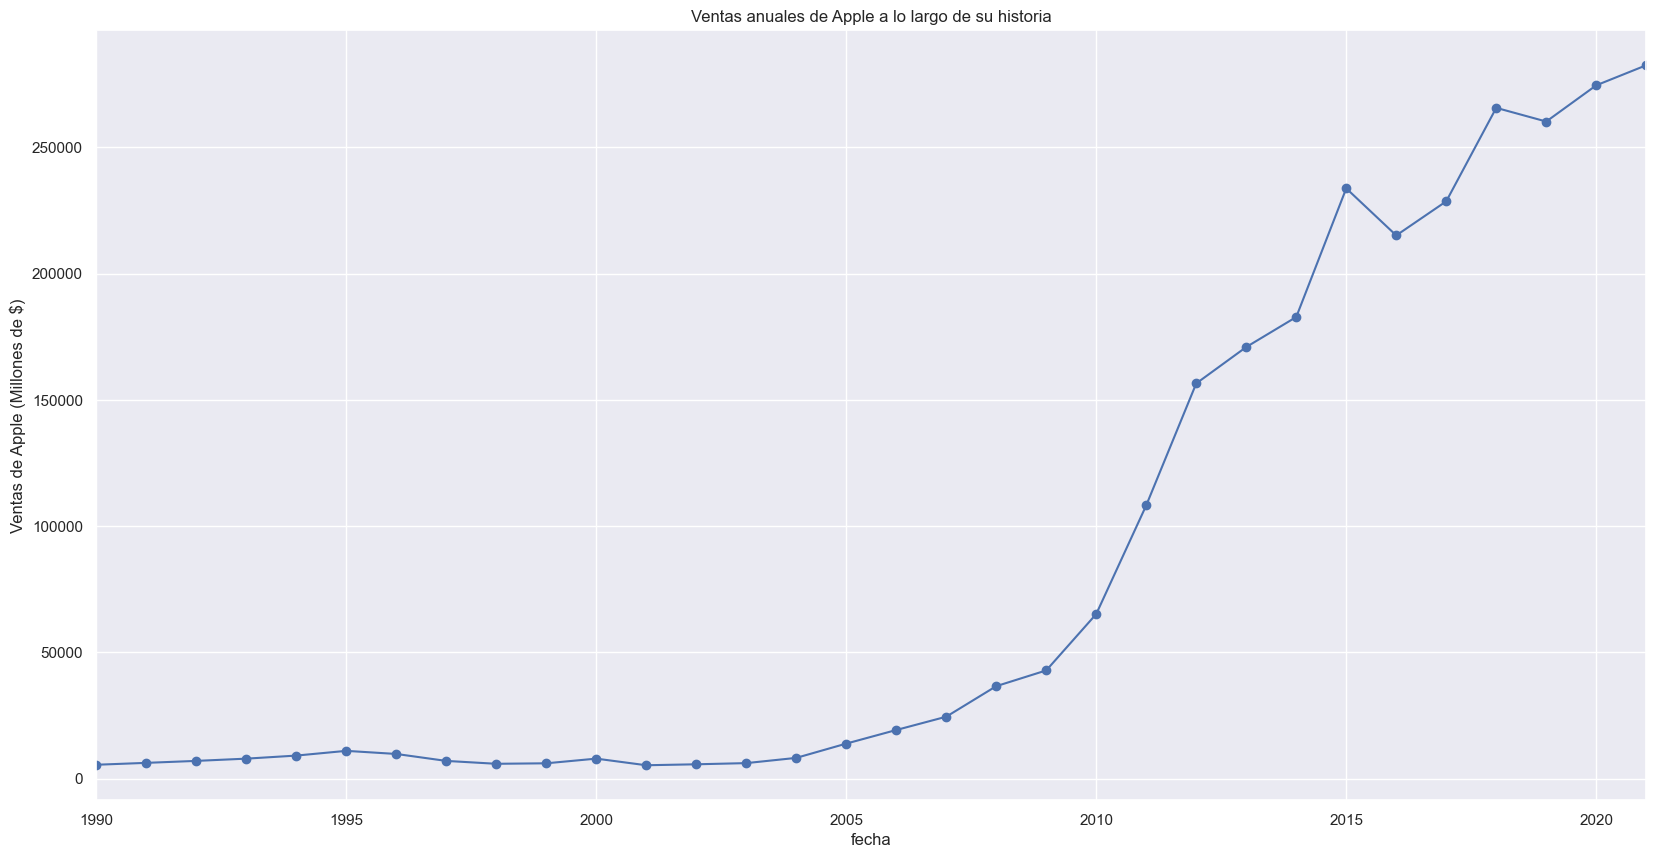

In [66]:
sns.set(rc={'figure.figsize':(20, 10)})
ax = apple_anual['Ingresos (Millones USD)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas de Apple (Millones de $)');
plt.title('Ventas anuales de Apple a lo largo de su historia')

Text(0.5, 1.0, 'Variación de las ventas anuales a lo largo de su historia')

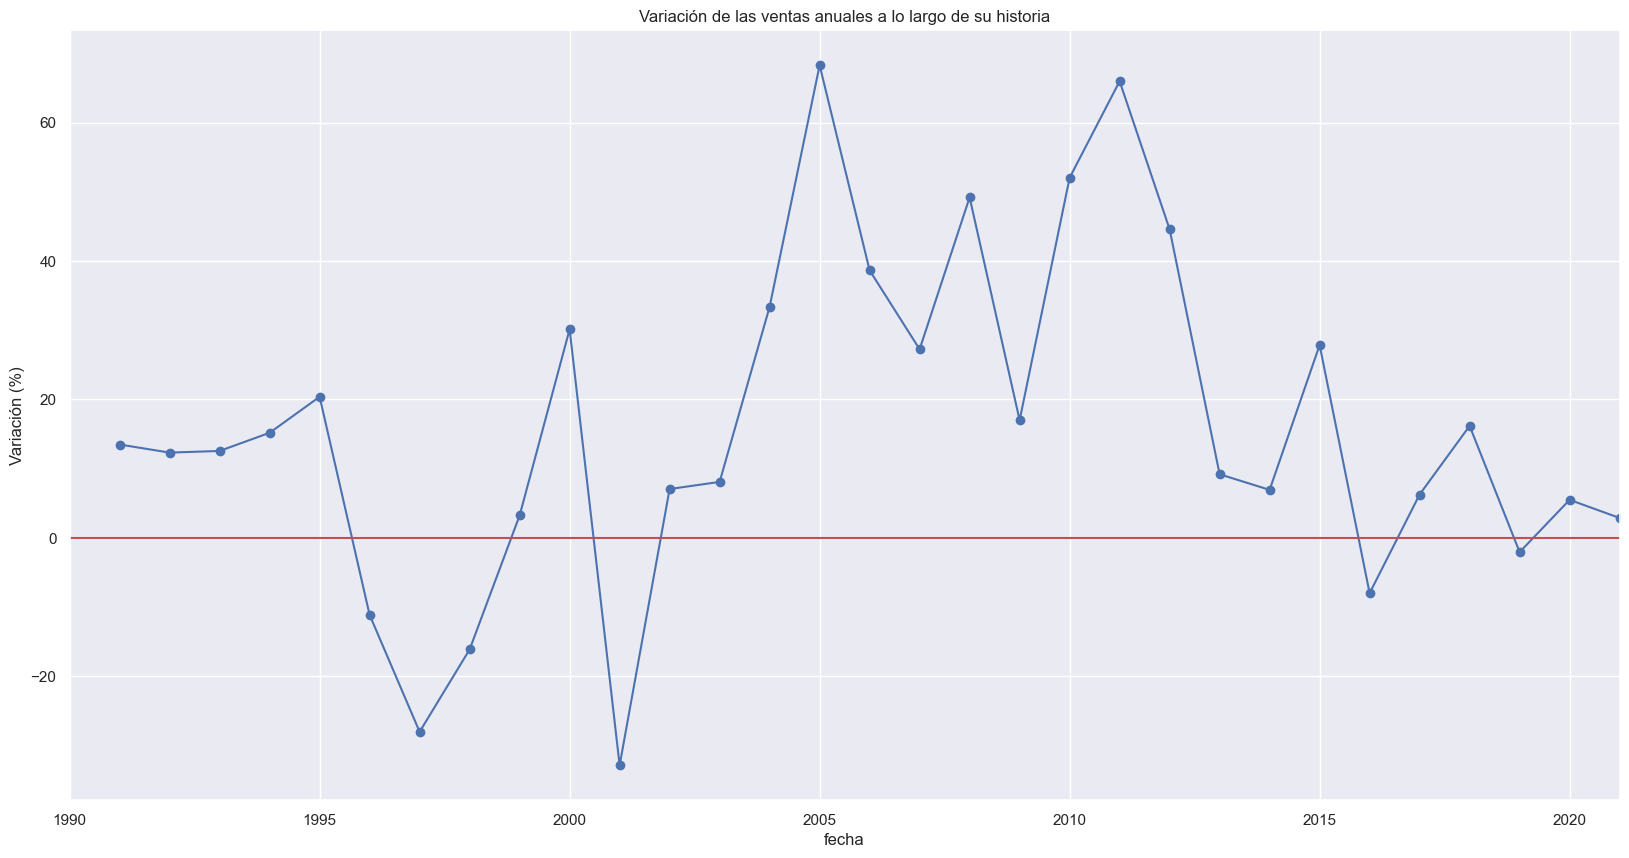

In [67]:
sns.set(rc={'figure.figsize':(20, 10)})
ax = apple_anual['Variación (%)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Variación (%)');
plt.axhline(y=0.0, color='r', linestyle='-')
plt.title('Variación de las ventas anuales a lo largo de su historia')

Tal y como se veía en la tendencia, los ingresos han ido aumentando año tras año, excepto en 2016 o 2020 que los ingresos cayeron.

## <a name="barclays"> 11. Comparación de las predicciones del modelo ARIMA con las de Barclays </a>

Una vez realizadas las predicciones, ya podemos añadirlas a los resultados reales de 2021 y tener el nº de ventas acumuladas tanto en 2021 como 2022.

In [68]:
predicciones = apple_trimestral['Ingresos'].astype('float64').to_period('Q-OCT').append(apple_pred_arima2)

predicciones_anuales = round(predicciones.resample('A-OCT').sum(),2)
predicciones_anuales.tail(10)

2014    182795.00
2015    233715.00
2016    215091.00
2017    228594.00
2018    265595.00
2019    260174.00
2020    274515.00
2021    372352.06
2022    437957.90
2023    153161.50
Freq: A-OCT, dtype: float64

In [69]:
predicciones_df = pd.DataFrame({'Año Fiscal':predicciones_anuales.index,'Datos ARIMA':predicciones_anuales.round(1)})
predicciones_df = predicciones_df.tail(n=4).set_index('Año Fiscal')
predicciones_df['Datos Barclays'] = [274515.0,368925,378619,384282]
predicciones_df['Variación (%)'] = ((predicciones_df['Datos ARIMA']/predicciones_df['Datos Barclays'])*100)-100

In [70]:
predicciones_df.head(3)

,Datos ARIMA,Datos Barclays,Variación (%)
Año Fiscal,,,
2020,274515.0,274515.0,0.000000
2021,372352.1,368925.0,0.928942
2022,437957.9,378619.0,15.672457


Respecto a las predicciones del modelo ARIMA frente a las de Barclays, observamos que las del año 2021 son muy similares con tan solo un 0,92% de diferencia en el año 2021. Sin emabrgo, para el año 2022, nuestro modelo ARIMA estima unos ingresos bastante más superiores que los del barclays, con una variacion del 15%

[Ir arriba del documento](#top)